In [186]:
import pandas as pd
import seaborn as sns
import scipy.stats as st

In [187]:
candidate_sentences = pd.read_csv("candidate_sentences-gpt2-annotated.csv", index_col=0)

In [188]:
# Drop manually excluded
candidate_sentences = candidate_sentences[candidate_sentences["JG exclude"].isna()]

In [189]:
# only retain words+sentences which have >= 1 sentence for high and low labels
print(candidate_sentences.groupby("target_word").ngroups)
candidate_sentences = candidate_sentences.groupby(["target_word"]).filter(lambda x: x["label"].nunique() == 2)
print(candidate_sentences.groupby("target_word").ngroups)

129
107


In [190]:
words = pd.read_csv("adopted_df_blocks_withBalancedUnion.csv")

## Rejection sampling method

In [191]:
merged = pd.merge(candidate_sentences, words, left_on="target_word", right_on="word_us")

In [192]:
merged.groupby("COND").apply(lambda xs: xs.target_word.nunique())

/tmp/ipykernel_3428809/3314950437.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged.groupby("COND").apply(lambda xs: xs.target_word.nunique())


COND
O+P+    26
O+P-    25
O-P+    27
O-P-    29
dtype: int64

In [193]:
word_sample_size = 20

# we want to maximize differences in these variables between conditions
max_variables = ["surprisal", "ortho_n_dens_s", "phono_n_dens_s"]
# we want to minimize differences in these variables between conditions
min_variables = ["word_length", "n_phon", "n_syll", "sum_bigram", "sum_biphone", "lgsubtlwf", "concrete_m", "aff_val_m", "aff_arou_m"]

def get_sample():
    s_words = words.groupby("COND").sample(20, replace=False)
    s_sentences = pd.merge(candidate_sentences, s_words, left_on="target_word", right_on="word_us").groupby(["target_word", "label"]).sample(1)

    s_melted = s_sentences.reset_index().melt(
        id_vars=["target_word", "label", "COND", "sentence"],
        value_vars=["surprisal", "entropy", "word_length", "ortho_n_dens_s",
                    "ortho_n_freq_s_m", "ortho_upoint", "old20_m",
                    "sum_bigram", "n_phon", "n_syll", "phono_n_dens_s",
                    "phono_n_freq_s_m", "phono_upoint", "pld20_m",
                    "sum_biphone", "lgsubtlwf", "concrete_m",
                    "aff_val_m", "aff_arou_m"])
    s_melted["our_cond"] = s_melted.COND + " " + s_melted.label

    return s_words, s_sentences, s_melted

def get_stats(melted_df):
    return melted_df.groupby("variable").apply(lambda x: pd.Series(st.f_oneway(*[x.loc[x.our_cond == cond, "value"] for cond in x.our_cond.unique()]), index=["F", "p"]), include_groups=False)

def objective(melted_df):
    results = get_stats(melted_df)

    # max_p = results.loc[max_variables, "p"].min()
    min_p = results.loc[min_variables, "p"].min()

    # it's easy to maximize the max variables -- let's focus on the min variables
    # return max_diff - min_diff
    
    return min_p

In [194]:
best_sample = None
best_objective = float("-inf")

for i in range(1000):
    s_words, s_sentences, s_melted = get_sample()
    obj = objective(s_melted)

    if obj > best_objective:
        print(i, best_objective)
        best_objective = obj
        best_sample = s_words, s_sentences, s_melted

0 -inf
2 0.00036292526441358955
4 0.0025140797903638458
17 0.0048851269102273415
40 0.012367021224719044
44 0.014706323954820535
49 0.016266593914118083
74 0.018404385540588212
80 0.020057648382641687
187 0.03690507736444943
331 0.04835988852217942
881 0.07856574450478952


In [203]:
# sample id is a hash of the current timestamp
from time import time
from hashlib import sha1
sample_id = sha1(str(int(time())).encode()).hexdigest()[:8]
print(sample_id)

s_words.to_csv(f"{sample_id}-words.csv")
s_sentences.to_csv(f"{sample_id}-sentences.csv")
s_melted.to_csv(f"{sample_id}-melted.csv")

s_stats = get_stats(best_sample[2]).sort_values("p")
s_stats.to_csv(f"{sample_id}-stats.csv")

65759dfe


In [207]:
s_stats

,F,p
variable,,
surprisal,413.315443,7.338260e-79
old20_m,27.197503,8.894046e-22
ortho_n_dens_s,14.304987,2.690148e-13
pld20_m,11.040231,1.233651e-10
phono_n_dens_s,6.178727,3.728581e-06
phono_n_freq_s_m,4.179825,3.868760e-04
sum_bigram,1.869831,8.070853e-02
word_length,1.606076,1.404365e-01
concrete_m,1.143096,3.412661e-01


/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Target manipulations')

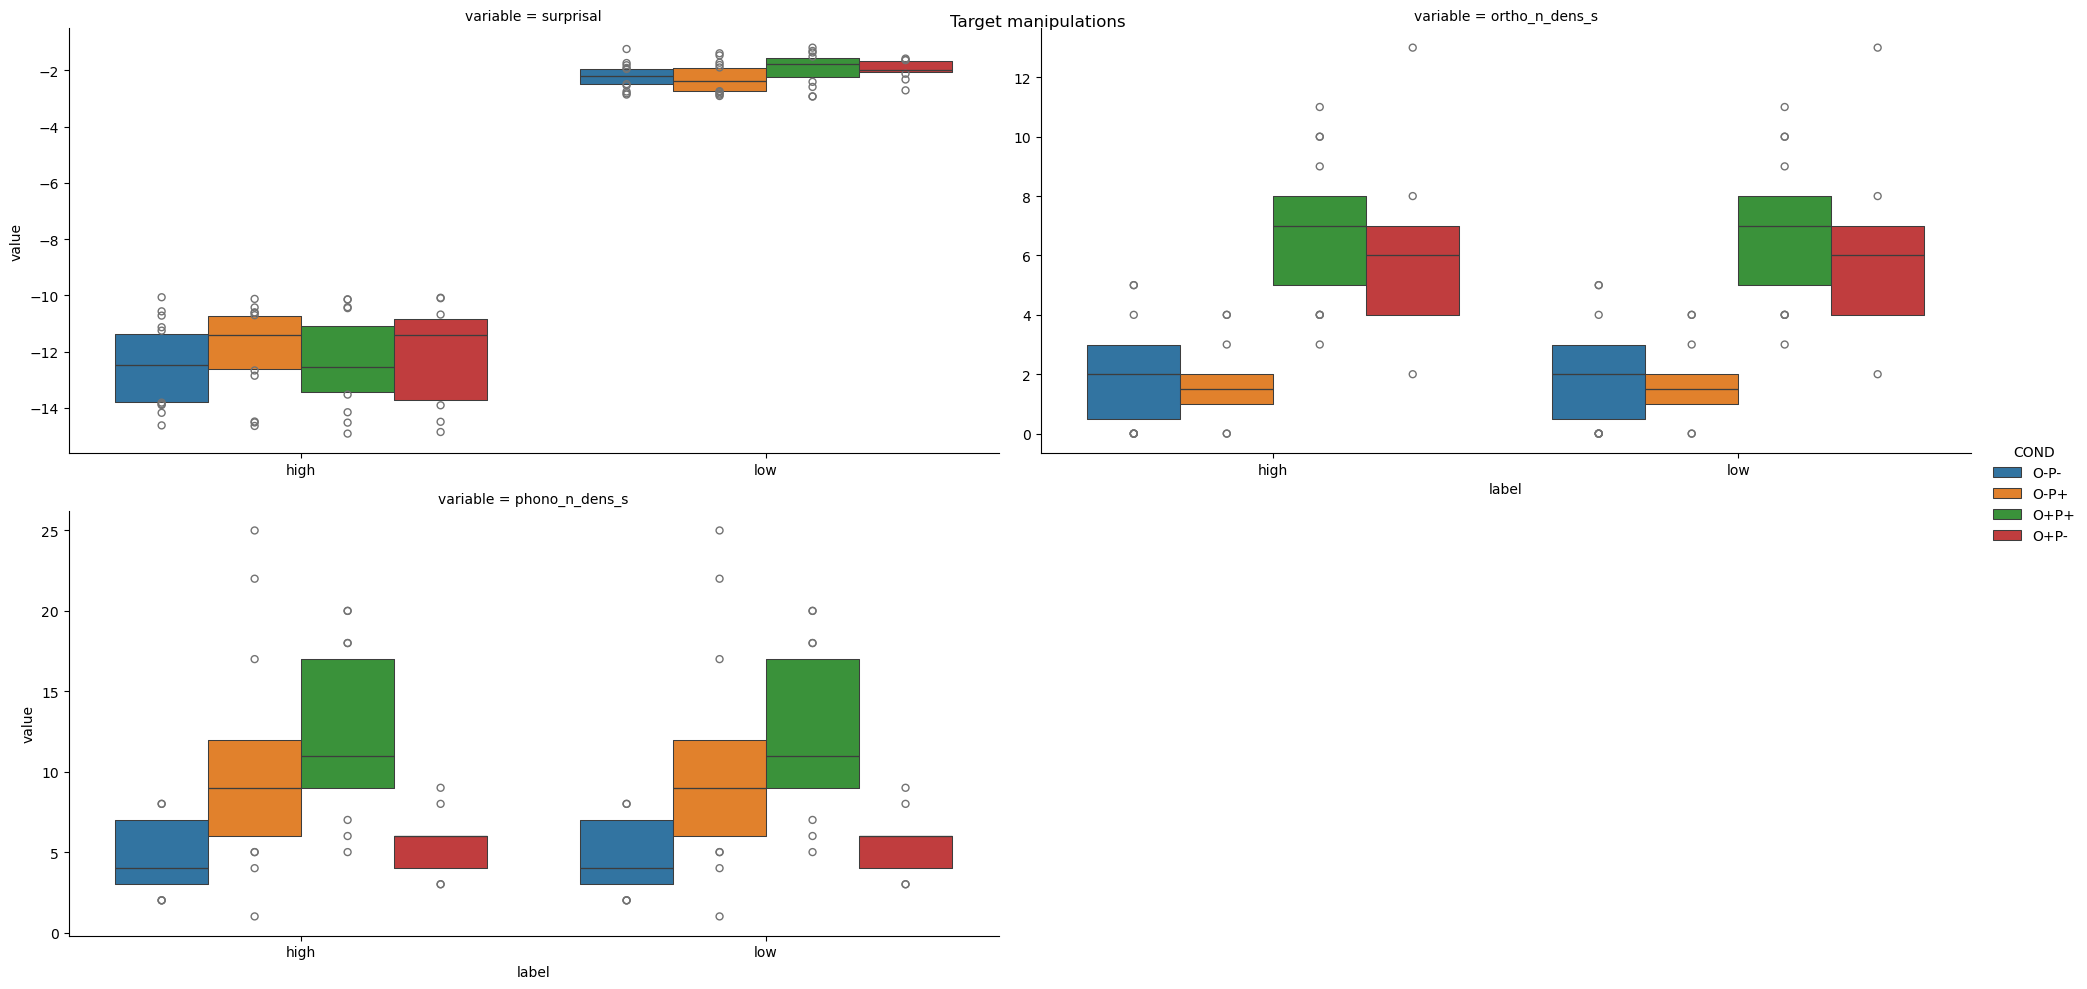

In [204]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(max_variables)], x="label", hue="COND", y="value", col="variable",
                col_wrap=2, kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Target manipulations")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Aim to match between conditions')

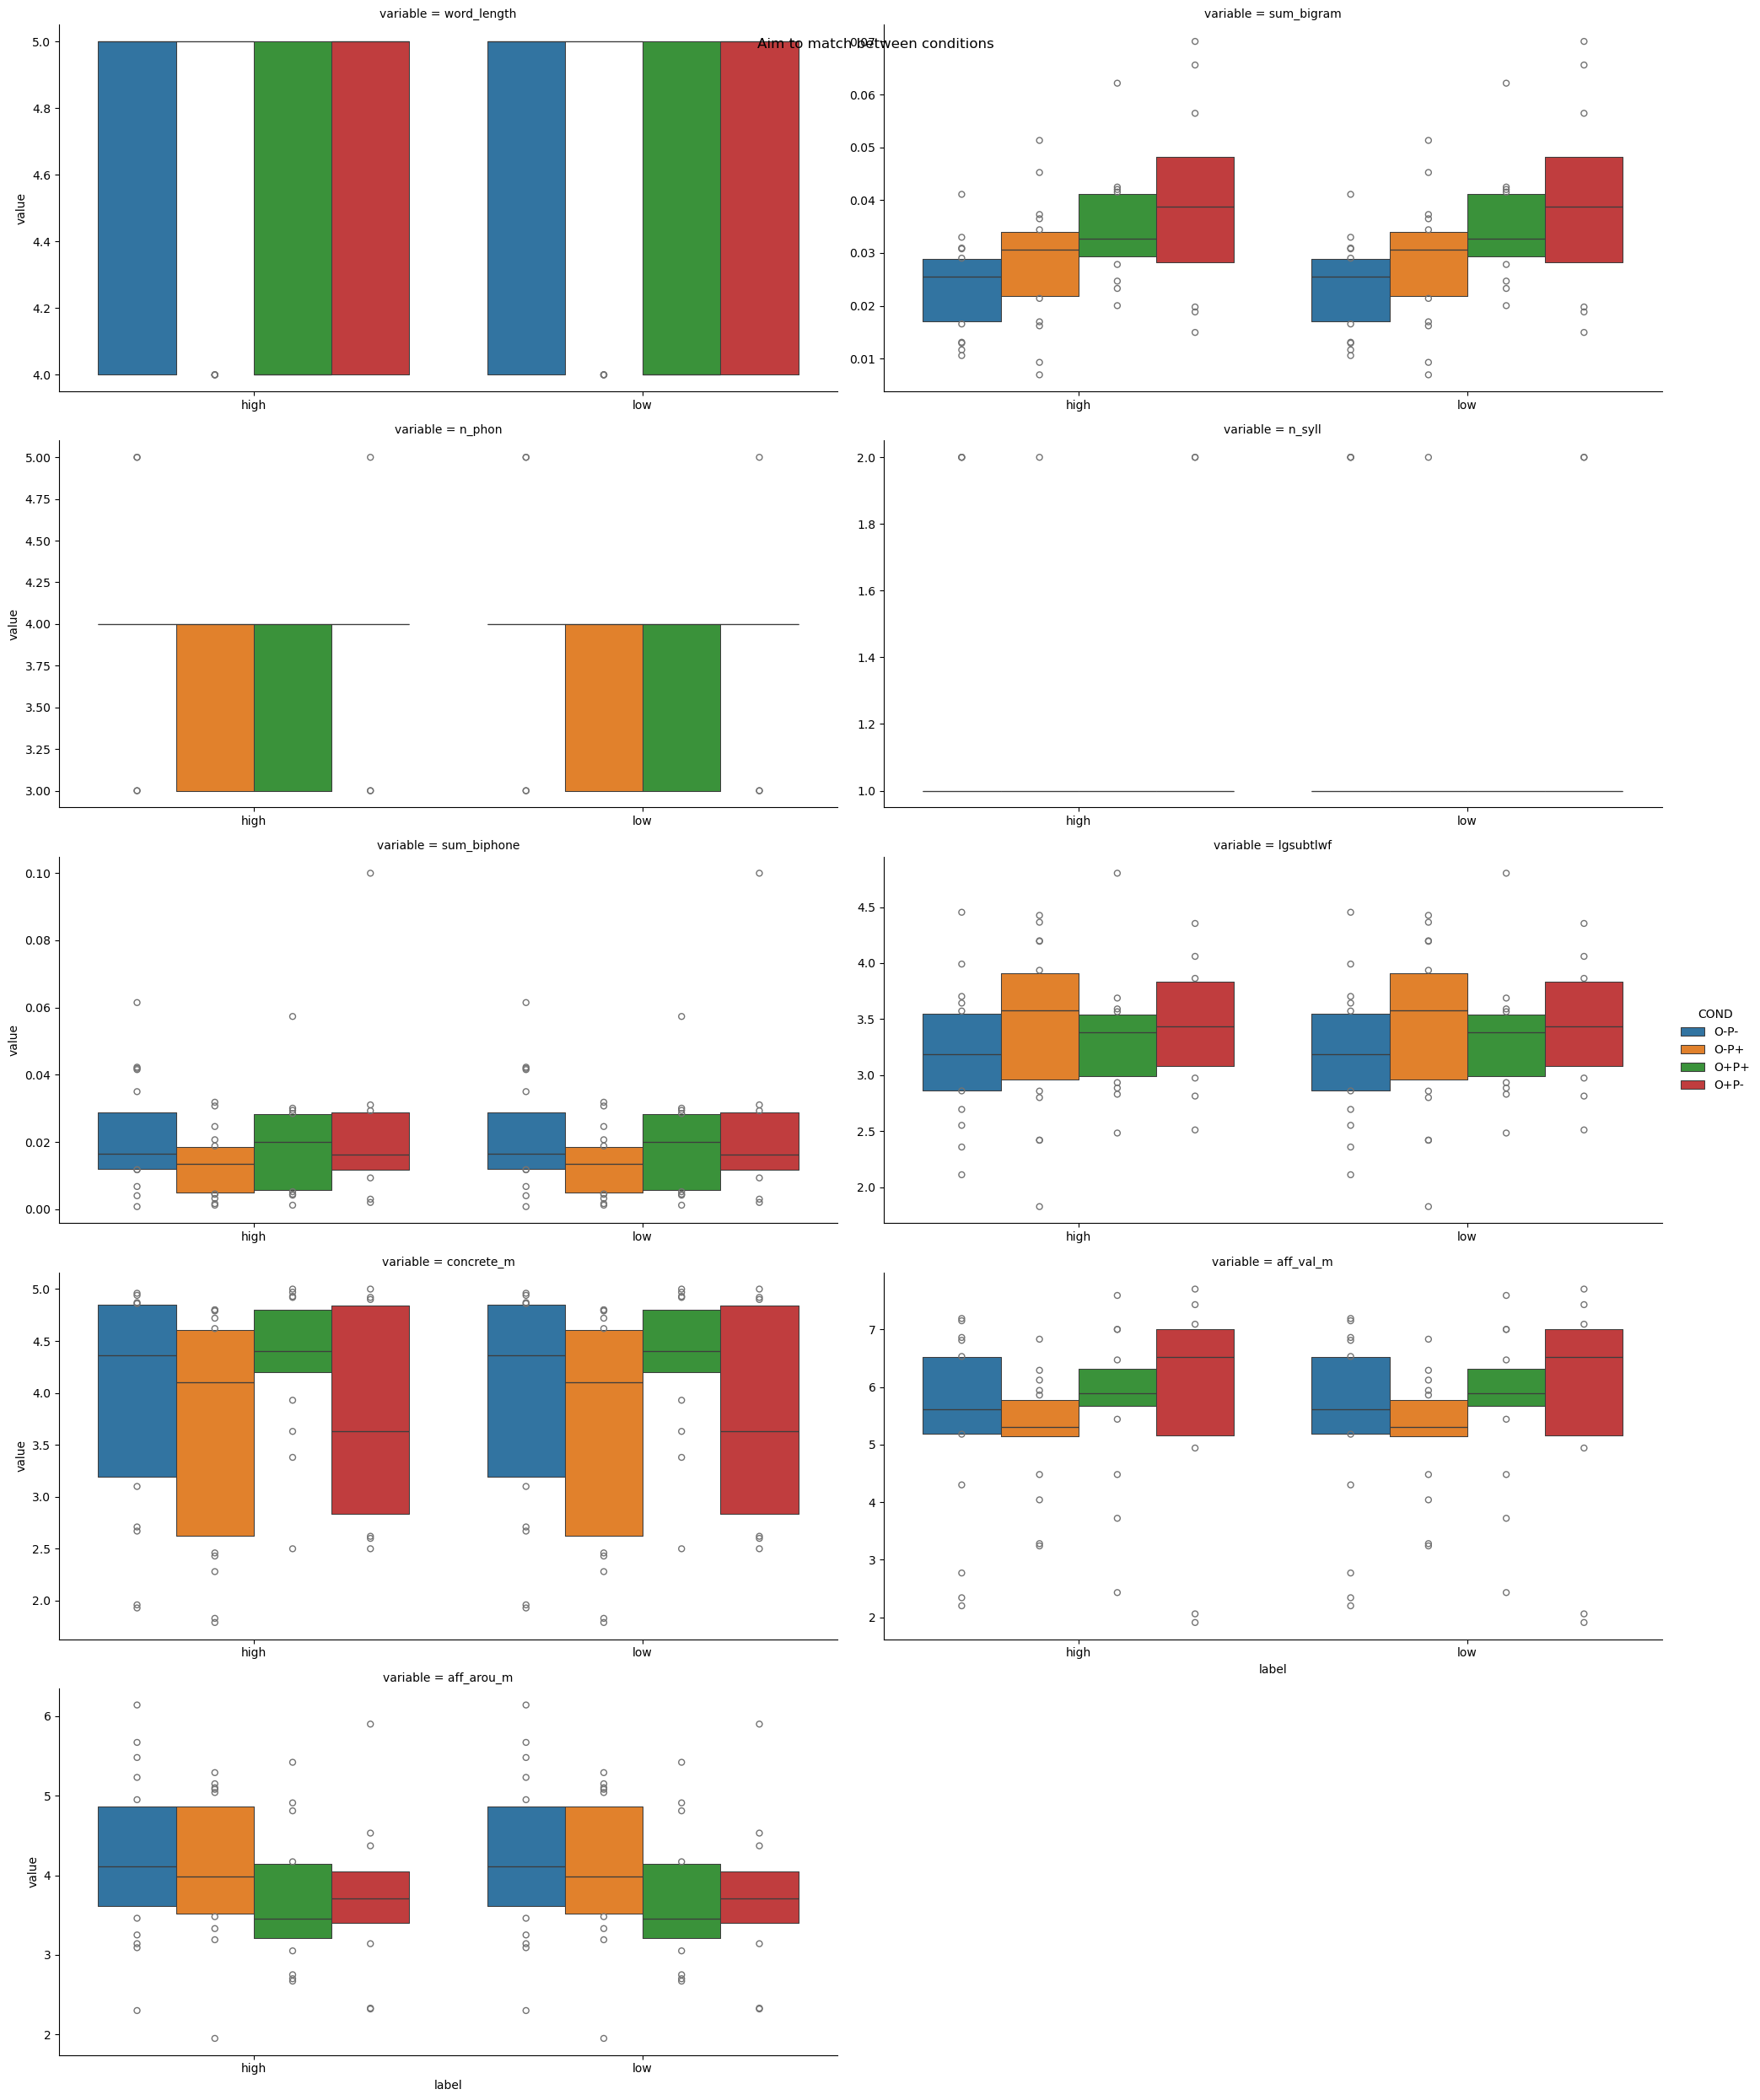

In [205]:
g = sns.catplot(data=s_melted[s_melted.variable.isin(min_variables)], x="label", hue="COND", y="value", col="variable",
                col_wrap=2, kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Aim to match between conditions")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 0.98, 'Other stuff')

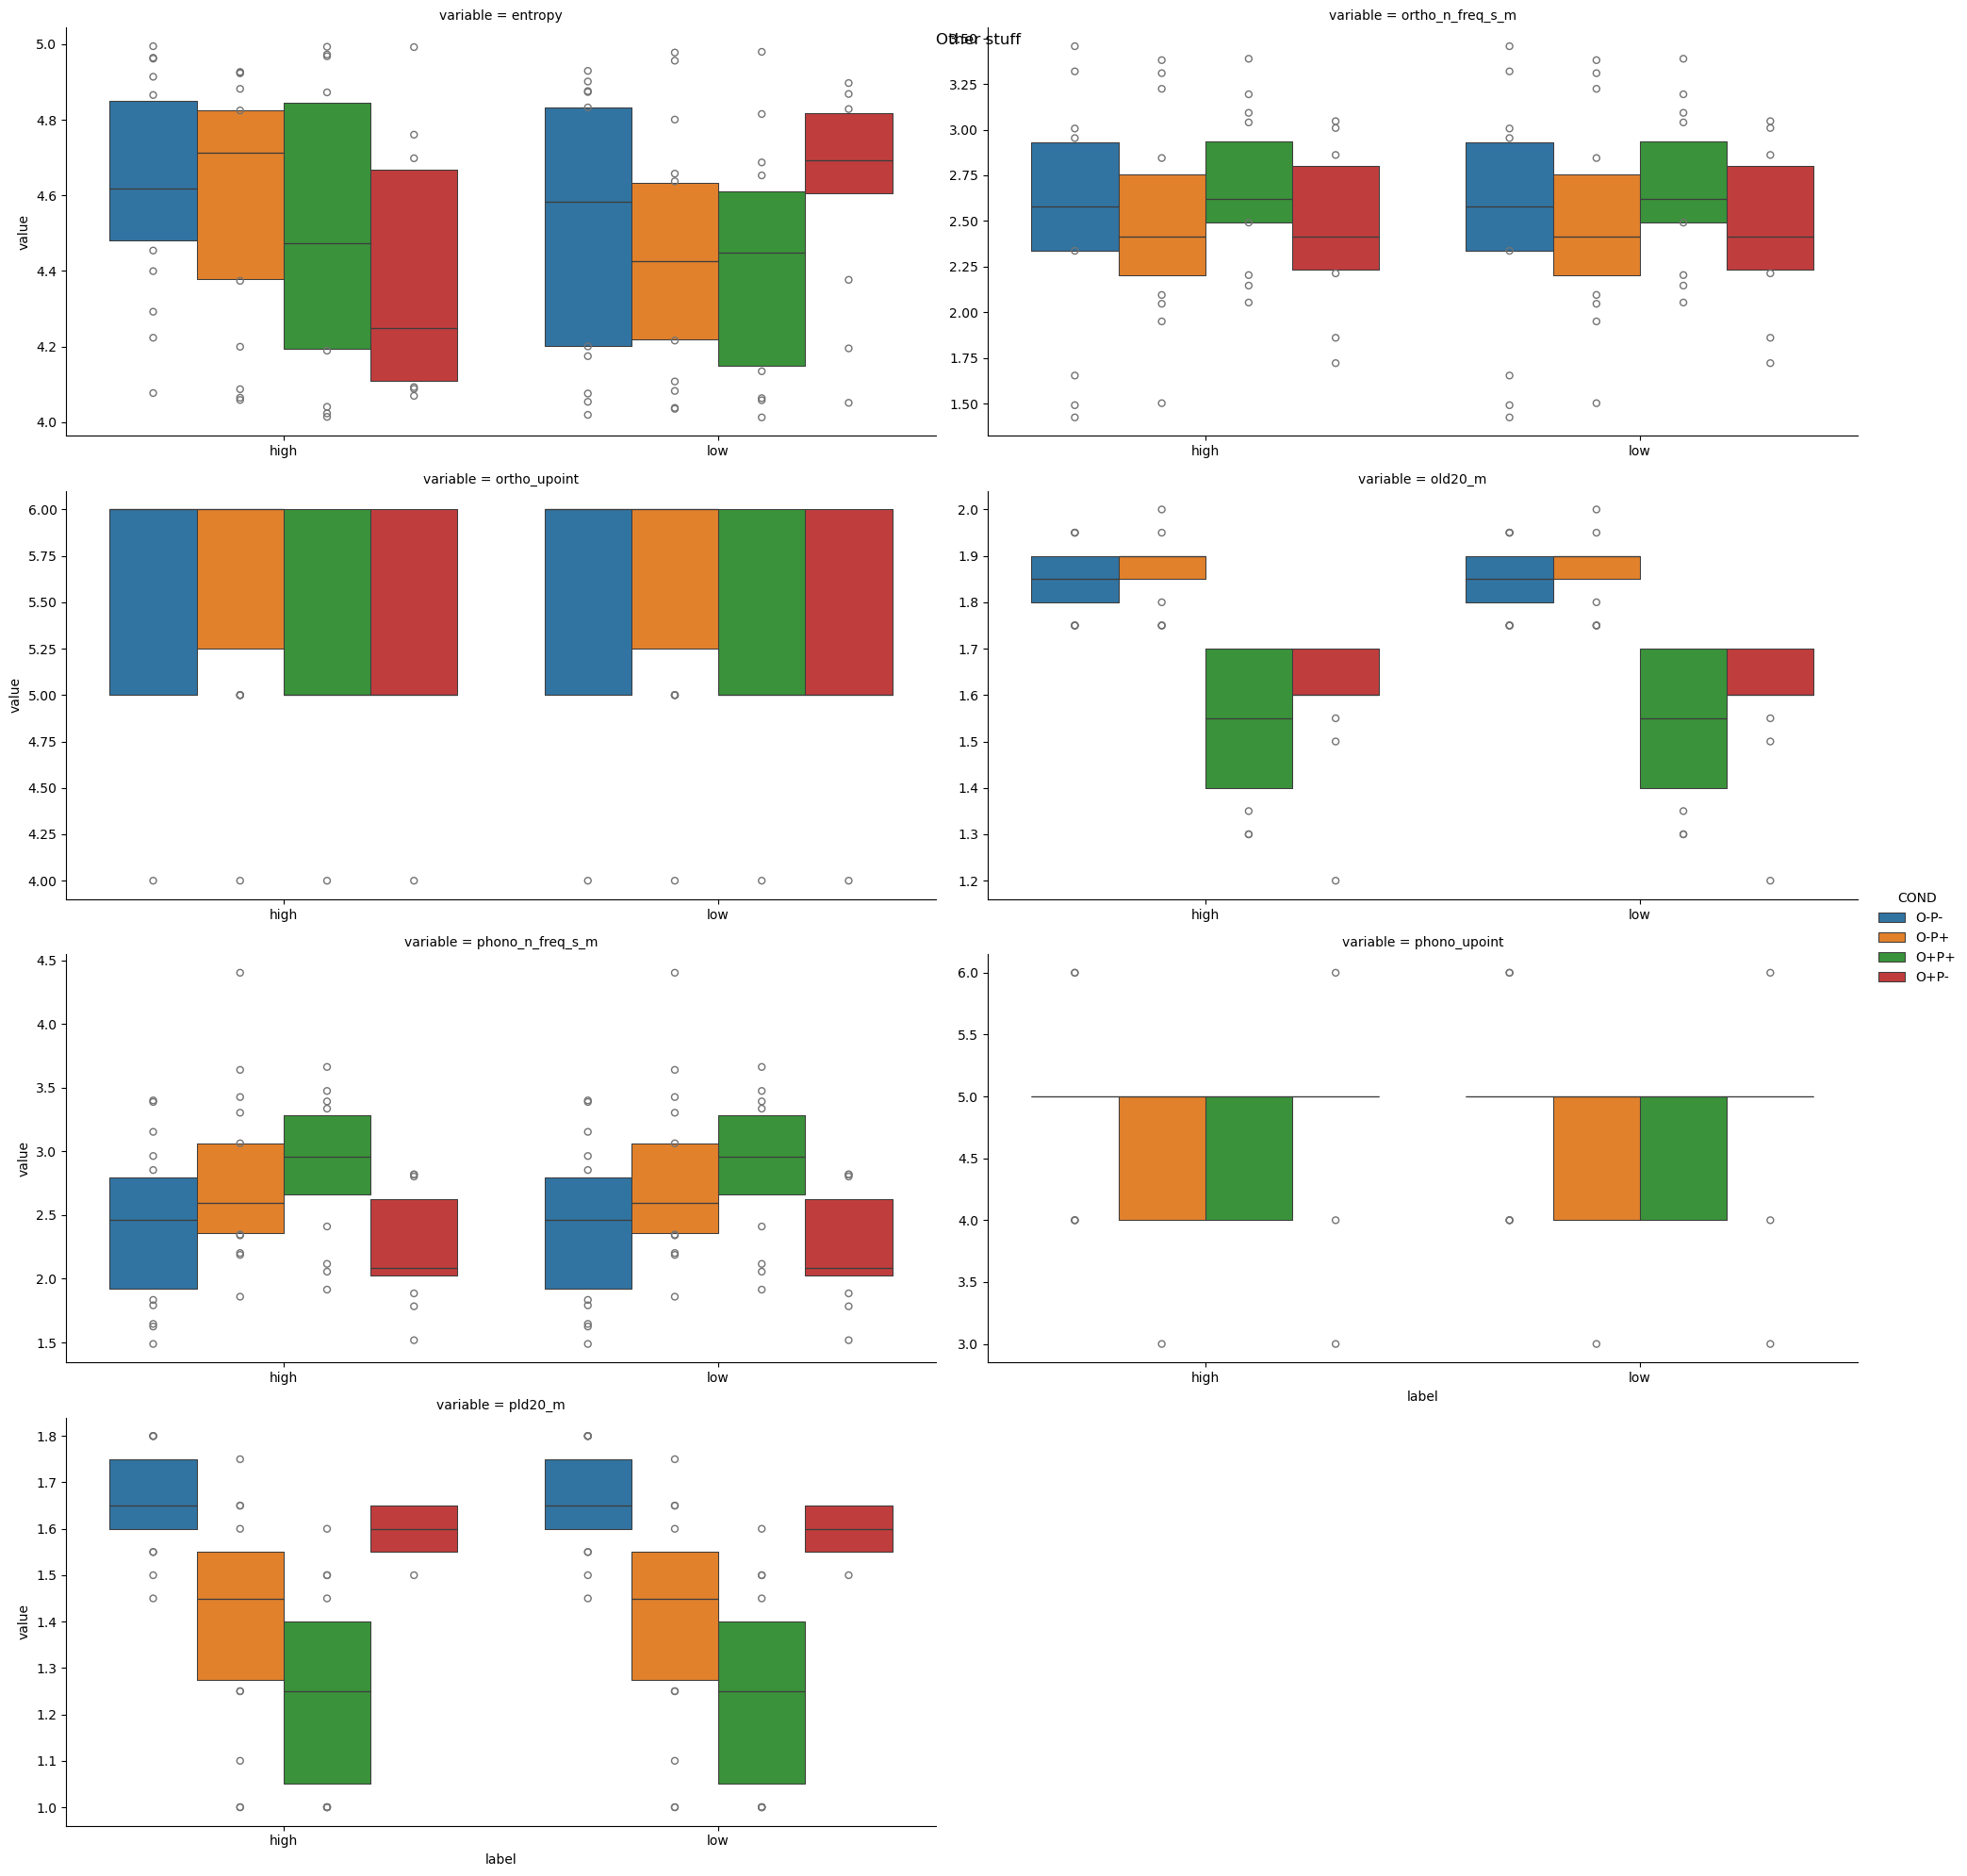

In [206]:
g = sns.catplot(data=s_melted[~s_melted.variable.isin(min_variables + max_variables)], x="label", hue="COND", y="value", col="variable",
                col_wrap=2, kind="boxen", aspect=2, sharex=False, sharey=False)
g.fig.suptitle("Other stuff")